In [1]:
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json
from datasets import load_dataset
from sklearn.model_selection import train_test_split

/home/mgyukim/.conda/envs/llama/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only

from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
#!wget https://raw.githubusercontent.com/korquad/korquad.github.io/master/dataset/KorQuAD_v1.0_train.json -O KorQuAD_v1.0_train.json
#!wget https://raw.githubusercontent.com/korquad/korquad.github.io/master/dataset/KorQuAD_v1.0_dev.json -O KorQuAD_v1.0_dev.json

In [4]:
def korquad_to_dataframe(data):
    rows = []
    for paragraph in data["data"]:
        paragraph_title = paragraph["title"]

        for qa in paragraph["paragraphs"]:
            context = qa["context"]

            for question in qa["qas"]:
                q = question["question"]
                qa_id = question["id"]

                for answer in question["answers"]:
                    a = answer["text"]
                    rows.append({
                        'question' : q,
                        'answer' : a,
                        'qa_id' : qa_id,
                        "context" : context,
                        'paragraph_title' : paragraph_title
                    })
    return pd.DataFrame(rows)


In [5]:
with open('./KorQuAD_v1.0_dev.json', 'r') as f:
    dev_data = json.load(f)

with open('./KorQuAD_v1.0_train.json', 'r') as f:
    train_data = json.load(f)

df_dev = korquad_to_dataframe(dev_data)
print(df_dev.shape)
df_dev.head(20)


(5774, 5)


,question,answer,qa_id,context,paragraph_title
0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일,6548850-0-0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,임수경,6548850-0-1,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
2,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년,6548853-0-0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
3,임종석을 검거한 장소는 경희대 내 어디인가?,학생회관 건물 계단,6548853-0-1,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
4,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,서울지방경찰청 공안분실,6548853-0-2,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
5,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?,임종석,6332405-0-0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
6,임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?,여의도 농민 폭력 시위,6332405-0-1,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석
7,정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄...,허영,6548850-1-0,"""내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다"", ""행보가 비서 본연의...",임종석
8,"'행보가 비서 본연의 역할을 벗어난다', '장관들과 내각이 소외되고 대통령비서실의 ...",10차 개헌안 발표,6548850-1-1,"""내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다"", ""행보가 비서 본연의...",임종석
9,국무회의의 심의를 거쳐야 한다는 헌법 제 몇 조의 내용인가?,제89조,6332405-1-0,"""내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다"", ""행보가 비서 본연의...",임종석


In [21]:
df_train = korquad_to_dataframe(train_data)
print(df_train.shape)
df_train["answer"][0]

(60407, 5)


'교향곡'

In [7]:
df_train = df_train[["question", "context", "answer"]]
df_dev = df_dev[["question", "context", "answer"]]

df = pd.concat([df_train, df_dev]).reset_index(drop=True)
df.isnull().value_counts()

question  context  answer
False     False    False     66181
Name: count, dtype: int64

In [8]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth 2024.10.7: Fast Llama patching. Transformers = 4.46.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.65 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.27. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [9]:
lora_model = FastLanguageModel.get_peft_model(
    model, 
    r = 16,
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none", 
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
    use_rslora = False,
    loftq_config = None
)

Unsloth 2024.10.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [10]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3072, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=3072, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default): I

In [11]:
lora_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [12]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1"
)

In [16]:
def format_example(row):
    prompt = f"""{row["question"]}

Information

###
{row["context"]}
###"""
    
    message = [
        {
            "role" : "system",
            "content" : "Use only the information to answer the question"
        },
        {"role" : "user", "content" : prompt},
        {"role" : "assistant", "content" : row["answer"]}
    ]

    return tokenizer.apply_chat_template(message, tokenize=False)

In [18]:
df["text"] = df.apply(format_example, axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,question,context,answer,text
0,"디시인사이드에서 조사한 ""2008년 올해 최고의 유행어는?""의 순위에 오른 발언을 ...",2008년 10월 국회에서 열린 국정감사에서 민주당 이종걸 의원의 대통령에 대한 비...,유인촌,<|begin_of_text|><|start_header_id|>system<|en...
1,이명박과 박근혜의 회동이 11개월만에 성사된 날은 언제인가?,2010년 8월 22일 이명박과 박근혜의 회동이 11개월만에 성사되었다. 95분동안...,2010년 8월 22일,<|begin_of_text|><|start_header_id|>system<|en...
2,해구 동쪽 지역에서는 어떤 형태의 여진이 발생 중인가?,본진 이후 일어나고 있는 여진은 이와테 현 앞바다부터 이바라키 현 앞바다까지 동서 ...,해양지각 내 지진,<|begin_of_text|><|start_header_id|>system<|en...
3,남쪽 탑에 설치된 스페시오사 종의 무게는 몇 kg인가?,1331년 신랑의 토대가 설치되었고 2년 후인 1333년에 프란체스코 페트라르카가 ...,"5,200kg",<|begin_of_text|><|start_header_id|>system<|en...
4,천문학 집대성의 아랍어 역본은?,프톨레마이오스가 알렉산드리아의 그리스 사회 일원이라는 것 외에 삶의 세밀한 부분은 ...,알마게스트,<|begin_of_text|><|start_header_id|>system<|en...


In [22]:
print(df.loc[0,'text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

디시인사이드에서 조사한 "2008년 올해 최고의 유행어는?"의 순위에 오른 발언을 한 사람은?

Information

###
2008년 10월 국회에서 열린 국정감사에서 민주당 이종걸 의원의 대통령에 대한 비난에 대해 정회 후 반발하는 과정에서 기자들에게 손가락질을 하며 "찍지마! XX 찍지마. 성질이 뻗쳐서 정말" 이라는 욕설 발언을 하여 크게 비판을 받았다. 당시 수많은 기자들이 있는 상황에서 이 발언이 모두 녹화되었으며 민주당을 비롯한 야당은 유 장관의 이런 행위가 국회를 모독한 것이라며 반드시 책임을 묻겠다고 말하였다. 유 장관은 현장에서 바로 사진 기자들에게 사과를 하고 욕설이 아니었다고 해명자료를 배포했으며, 이틀 후 다시 공식 브리핑을 통해 사과했다. 유인촌이 국정감사장에서 한 발언은 2008년에 디시인사이드에서 조사한 "2008년 올해 최고의 유행어는?"의 순위에 오르기도 하였다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

유인촌<|eot_id|>


In [24]:
%%time
def count_tokens(row):
    return len(
        tokenizer(
            row['text'],
            add_special_tokens=True,
            return_attention_mask=False
        )["input_ids"]
    )


df["token_count"] = df.apply(count_tokens, axis=1)

CPU times: user 39.5 s, sys: 0 ns, total: 39.5 s
Wall time: 39.5 s


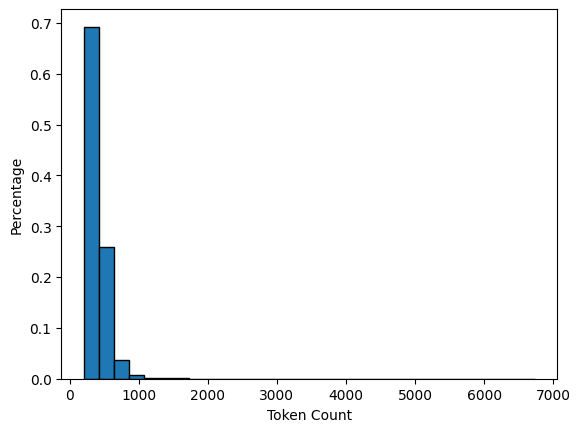

(57139, 66181, 0.8633746845771445)

In [26]:
df.head()
plt.hist(df["token_count"], ec="k", bins=30, 
         weights=np.ones(len(df["token_count"])) / len(df["token_count"]))
plt.xlabel("Token Count")
plt.ylabel("Percentage")
plt.show()

len(df[df["token_count"] < 512]), len(df), len(df[df['token_count'] < 512]) / len(df)

In [27]:
SEED = 42

# 토큰 길이로 적당히 학습 샘플 서브샘플링 
df_sampled = df[df["token_count"] < 512]
df_sampled = df_sampled.sample(6000, random_state=SEED)
df_sampled.shape

(6000, 5)

In [28]:
train, temp = train_test_split(df_sampled, test_size=0.2, random_state=SEED)
val, test = train_test_split(temp, test_size=0.2, random_state=SEED)

In [29]:
print(f"Train data ratio:{len(train) / len(df_sampled)}, {len(train)}")
print(f"Valid data ratio:{len(val) / len(df_sampled)}, {len(val)}")
print(f"Test data ratio:{len(test) / len(df_sampled)}, {len(test)}")

Train data ratio:0.8, 4800
Valid data ratio:0.16, 960
Test data ratio:0.04, 240


In [30]:
train.sample(n=4000, random_state=SEED).to_json("train.json", orient="records", lines=True)
val.sample(n=500, random_state=SEED).to_json("val.json", orient="records", lines=True)
test.sample(n=100, random_state=SEED).to_json("test.json", orient="records", lines=True)

In [35]:
dataset = load_dataset(
    "json",
    data_files={
        "train" : "train.json",
        "validation" : "val.json",
        "test" : "test.json"
    }
)

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 4000
    })
    validation: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 500
    })
    test: Dataset({
        features: ['question', 'context', 'answer', 'text', 'token_count'],
        num_rows: 100
    })
})

In [37]:
def create_test_prompt(data_row):
    prompt = f"""{data_row["question"]}

Information

###
{data_row["context"]}
###"""

    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question"
        },
        {"role": "user", "content": prompt},
    ]

    return tokenizer.apply_chat_template(
        messages, tokenize=False,
        add_generation_prompt=True
    ) # 프롬프트 끝에 <|start_header_id|>assistant<|end_header_id|> 를 붙이게 됨

In [40]:
def int_test_one_sample(example, model):
    prompt = create_test_prompt(example)
    print("\nPROMPT\n", prompt.strip())

    inputs = torch.tensor(
        [tokenizer(prompt)["input_ids"]]
    ).to("cuda")

    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 64,
        use_cache = True,
        temperature = 1.5,
        min_p = 0.1
    )

    print("\nANS\n", example["answer"])
    print("\nPred\n", tokenizer.batch_decode(outputs)[0].split('<|start_header_id|>assistant<|end_header_id|>')[1].strip())

    return example['answer'], tokenizer.batch_decode(outputs)[0].split('<|start_header_id|>assistant<|end_header_id|>')[1].strip()

FastLanguageModel.for_inference(model);

In [41]:
# Append
untrained = []
untrained.append(
    int_test_one_sample(dataset["test"][0], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

베리가 사용했던 기타는 무엇인가?

Information

###
1970년대의 베리는 그의 초기 성공이 뒷받침되어 투어를 성사시켰다. 그는 수년간 깁슨 기타를 짊어지고 어디로 가든 밴드가 자신의 음악을 알고 있을 것이라고 확신하면서 이들을 고용하며 먼 길을 떠났다. 올뮤직은 이 시기 그의 "라이브 공연은 계속해서 불규칙해졌다 ... 끔찍한 백업 밴드와 협연하여 설렁하며, 가락 안 맞는 공연을 보여줬다."면서 그의 명성에 먹칠을 했다고 평론했다. 1972년 3월에는 쉐퍼드 부시에 위치한 BBC 텔레비전 시어터에서, 밴드 라킹 호스(Rocking Horse)가 백업한 60일의 투어 중 일부인 《척 베리 인 콘서트》를 위해 영화를 찍는다. 1970년대 그와 함께한 수많은 백업 뮤지션 중에서는 막 음악을 시작한 브루스 스프링스틴과 스티브 밀러가 있었다. 스프링스틴은 다큐멘터리 영화 《헤일! 헤일! 로큰롤》에서 베리가 밴드에게 세트 리스트를 주지 않았으며, 그는 자신의 기타 인트로를 듣고 그들이 알아서 자신에게 따라올 것이라 기대했다고 말했다. 베리는 공연 이후 밴드에게 고맙다는 인사 하나 없었다. 그렇지만, 스프링스틴은 그가 1995년에 로큰롤 명예의 전당 콘서트를 할 때 베리의 백업을 다시금 맡아주었다. 지미 카터의 요청에 의해 베리는 1979년 6월 1일 백악관에서 공연하기도 했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>



ANS
 깁슨 기타

Pred
 그의 밴드에 밴드 "로킹 호스(Rocking Horse)"의 가ît로, 1972년 3월 BBC 텔레비전 시어터에서, 1970년대 그와 함께한 수많은 백업 뮤지션 중에서도, 막


In [42]:
untrained.append(
    int_test_one_sample(dataset['test'][1], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

일본의 공식 웹사이트에 바이오하자드 엄브렐러 크로니클즈 티저 영상이 공개된 날짜는?

Information

###
2006년 11월 3일에 열린 닌텐도 월드에서는 2007년에 발매될 예정이라는 발표와 함께 게임의 영상이 공개되었다. 2007년 4월 6일에는 일본의 공식 웹사이트에서 티저 영상을 공개하였다. 이어서 2007년 4월 13일에는 캐릭터 프로필과 스크린샷이 포함된 두 번째 트레일러가 공개되었다. 캡콤의 기획 및 조사 디렉터 크리스티안 스벤슨은 게임이 480의 순차 주사 방식과 16:9의 와이드스크린을 지원할 것이라고 언급하였다. 《바이오하자드 4 위 에디션》에도 특전 영상으로 트레일러가 포함되어 있는데, 여기에 포함된 영상은 오리지널의 양관과 라쿤 시의 일부 지역을 보여주었다. 2007년 7월 11일의 E3에서 닌텐도 측은 총 악세사리인 Wii 재퍼를 게임에서 사용할 수 있다고 언급하였다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 2007년 4월 6일

Pred
 2007년 4월 6일 일본의 공식 웹사이트에서 TIzer 영상을 공개하였다.<|eot_id|>


In [43]:
untrained.append(
    int_test_one_sample(dataset['test'][2], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

폰티액전쟁을 학살의 광기로 묘사한 사학자는?

Information

###
영국 정착민과 인디언과의 관계는, 프렌치 인디언 전쟁 때 극도의 긴장 관계에 있었지만, 폰티액 전쟁 동안에 오히려 완화됐다. 사학자 데이비드 딕슨은 “폰티액 전쟁은 양측 모두 학살의 광기에 취해 버린 듯, 그 무서운 폭력이 전례가 없던 것이었다.”고 평가했다. 사학자 다니엘 리히터는 인디언이 영국군을 몰아내려는 한 것과 팩스턴 보이즈가 백인 사회에서 인디언을 없애려고 한 것을 인종 청소의 예라고 생각했다. 전쟁에 관련된 양측 모두 정착민과 원주민은 본질적으로 다르며, 공생할 수 없다는 결론에 도달했다. 리히터는 이 전쟁이 “모든 원주민은 ‘인디언’이고 각 유럽계 미국인은 ‘백인’이며, 한쪽은 다른 한쪽을 파괴하기 위해 결속하는 새로운 사고방식을 가져 오게 되었다.”고 평했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 데이비드 딕슨

Pred
 다니엘 리히터<|eot_id|>


In [44]:
untrained.append(
    int_test_one_sample(dataset['test'][3], model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

쿠빌라이와 동맹을 맺고나서 카이두가 아리크 부케를 도왔다는 구실로 카이두를 공격한 인물은?

Information

###
1259년, 몽케 칸이 남송 원정 중 사망하자 다음 해인 1260년에 그의 동생인 쿠빌라이와 아리크 부케가 각각 대칸을 칭했다. 서로 대칸을 칭한 쿠빌라이와 아리크 부케는 곧바로 전쟁에 들어갔다. 전쟁은 중국 북부의 풍부한 물자를 가진 쿠빌라이에게 시종일관 유리하게 진행됐다. 이에 아리크 부케는 자신이 임명한 차가타이 칸국의 알루구에게 도움을 요청했지만 알루구는 이 요청을 거절하고 오히려 1263년에 쿠빌라이와 동맹을 맺었다. 쿠빌라이와 동맹을 맺은 알루구는 카이두가 아리크 부케를 도왔다는 구실로 카이두를 공격했다. 알루구의 공격을 받은 카이두는 킵차크 칸국의 베르케의 지원을 받아 차가타이 칸국의 영토로 침입하여 알루구와의 전투에서 승리를 거두었으나 다음 번 전투에서 반격을 당해 본국으로 철수했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 알루구

Pred
 알루구<|eot_id|>


In [45]:
untrained

[('깁슨 기타',
  '그의 밴드에 밴드 "로킹 호스(Rocking Horse)"의 가ît로, 1972년 3월 BBC 텔레비전 시어터에서, 1970년대 그와 함께한 수많은 백업 뮤지션 중에서도, 막'),
 ('2007년 4월 6일', '2007년 4월 6일 일본의 공식 웹사이트에서 TIzer 영상을 공개하였다.<|eot_id|>'),
 ('데이비드 딕슨', '다니엘 리히터<|eot_id|>'),
 ('알루구', '알루구<|eot_id|>')]

In [46]:
FastLanguageModel.for_inference(lora_model);
FastLanguageModel.for_training(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [48]:
import os
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

trainer = SFTTrainer(
    model = lora_model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["validation"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 1e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps",
        eval_steps=0.2,
        save_steps=0.2,
    ),
)

trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map: 100%|██████████| 500/500 [00:00<00:00, 7637.00 examples/s]
/home/mgyukim/.conda/envs/llama/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Map: 100%|██████████| 500/500 [00:00<00:00, 5363.15 examples/s]


In [49]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss,Validation Loss
100,0.183900,0.238357
200,0.028300,0.192190
300,0.279100,0.182273
400,0.233200,0.170069
500,0.138600,0.165058


In [50]:
trained = []
FastLanguageModel.for_inference(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
      

In [51]:
trained.append(
    int_test_one_sample(dataset['test'][0], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

베리가 사용했던 기타는 무엇인가?

Information

###
1970년대의 베리는 그의 초기 성공이 뒷받침되어 투어를 성사시켰다. 그는 수년간 깁슨 기타를 짊어지고 어디로 가든 밴드가 자신의 음악을 알고 있을 것이라고 확신하면서 이들을 고용하며 먼 길을 떠났다. 올뮤직은 이 시기 그의 "라이브 공연은 계속해서 불규칙해졌다 ... 끔찍한 백업 밴드와 협연하여 설렁하며, 가락 안 맞는 공연을 보여줬다."면서 그의 명성에 먹칠을 했다고 평론했다. 1972년 3월에는 쉐퍼드 부시에 위치한 BBC 텔레비전 시어터에서, 밴드 라킹 호스(Rocking Horse)가 백업한 60일의 투어 중 일부인 《척 베리 인 콘서트》를 위해 영화를 찍는다. 1970년대 그와 함께한 수많은 백업 뮤지션 중에서는 막 음악을 시작한 브루스 스프링스틴과 스티브 밀러가 있었다. 스프링스틴은 다큐멘터리 영화 《헤일! 헤일! 로큰롤》에서 베리가 밴드에게 세트 리스트를 주지 않았으며, 그는 자신의 기타 인트로를 듣고 그들이 알아서 자신에게 따라올 것이라 기대했다고 말했다. 베리는 공연 이후 밴드에게 고맙다는 인사 하나 없었다. 그렇지만, 스프링스틴은 그가 1995년에 로큰롤 명예의 전당 콘서트를 할 때 베리의 백업을 다시금 맡아주었다. 지미 카터의 요청에 의해 베리는 1979년 6월 1일 백악관에서 공연하기도 했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 깁슨 기타

Pred
 깁슨<|eot_id|>


In [52]:
trained.append(
    int_test_one_sample(dataset['test'][1], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

일본의 공식 웹사이트에 바이오하자드 엄브렐러 크로니클즈 티저 영상이 공개된 날짜는?

Information

###
2006년 11월 3일에 열린 닌텐도 월드에서는 2007년에 발매될 예정이라는 발표와 함께 게임의 영상이 공개되었다. 2007년 4월 6일에는 일본의 공식 웹사이트에서 티저 영상을 공개하였다. 이어서 2007년 4월 13일에는 캐릭터 프로필과 스크린샷이 포함된 두 번째 트레일러가 공개되었다. 캡콤의 기획 및 조사 디렉터 크리스티안 스벤슨은 게임이 480의 순차 주사 방식과 16:9의 와이드스크린을 지원할 것이라고 언급하였다. 《바이오하자드 4 위 에디션》에도 특전 영상으로 트레일러가 포함되어 있는데, 여기에 포함된 영상은 오리지널의 양관과 라쿤 시의 일부 지역을 보여주었다. 2007년 7월 11일의 E3에서 닌텐도 측은 총 악세사리인 Wii 재퍼를 게임에서 사용할 수 있다고 언급하였다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 2007년 4월 6일

Pred
 2007년 4월 6일<|eot_id|>


In [53]:
trained.append(
    int_test_one_sample(dataset['test'][2], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

폰티액전쟁을 학살의 광기로 묘사한 사학자는?

Information

###
영국 정착민과 인디언과의 관계는, 프렌치 인디언 전쟁 때 극도의 긴장 관계에 있었지만, 폰티액 전쟁 동안에 오히려 완화됐다. 사학자 데이비드 딕슨은 “폰티액 전쟁은 양측 모두 학살의 광기에 취해 버린 듯, 그 무서운 폭력이 전례가 없던 것이었다.”고 평가했다. 사학자 다니엘 리히터는 인디언이 영국군을 몰아내려는 한 것과 팩스턴 보이즈가 백인 사회에서 인디언을 없애려고 한 것을 인종 청소의 예라고 생각했다. 전쟁에 관련된 양측 모두 정착민과 원주민은 본질적으로 다르며, 공생할 수 없다는 결론에 도달했다. 리히터는 이 전쟁이 “모든 원주민은 ‘인디언’이고 각 유럽계 미국인은 ‘백인’이며, 한쪽은 다른 한쪽을 파괴하기 위해 결속하는 새로운 사고방식을 가져 오게 되었다.”고 평했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 데이비드 딕슨

Pred
 데이비드 딕슨<|eot_id|>


In [54]:
trained.append(
    int_test_one_sample(dataset['test'][3], lora_model)
)


PROMPT
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>user<|end_header_id|>

쿠빌라이와 동맹을 맺고나서 카이두가 아리크 부케를 도왔다는 구실로 카이두를 공격한 인물은?

Information

###
1259년, 몽케 칸이 남송 원정 중 사망하자 다음 해인 1260년에 그의 동생인 쿠빌라이와 아리크 부케가 각각 대칸을 칭했다. 서로 대칸을 칭한 쿠빌라이와 아리크 부케는 곧바로 전쟁에 들어갔다. 전쟁은 중국 북부의 풍부한 물자를 가진 쿠빌라이에게 시종일관 유리하게 진행됐다. 이에 아리크 부케는 자신이 임명한 차가타이 칸국의 알루구에게 도움을 요청했지만 알루구는 이 요청을 거절하고 오히려 1263년에 쿠빌라이와 동맹을 맺었다. 쿠빌라이와 동맹을 맺은 알루구는 카이두가 아리크 부케를 도왔다는 구실로 카이두를 공격했다. 알루구의 공격을 받은 카이두는 킵차크 칸국의 베르케의 지원을 받아 차가타이 칸국의 영토로 침입하여 알루구와의 전투에서 승리를 거두었으나 다음 번 전투에서 반격을 당해 본국으로 철수했다.
###<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ANS
 알루구

Pred
 알루구<|eot_id|>


In [55]:
pd.DataFrame(
    data=[(utrd[0], utrd[1], trd[1]) for utrd, trd in zip(untrained, trained)],
    columns=['정답', '학습전 출력', '학습후 출력']
)

,정답,학습전 출력,학습후 출력
0,깁슨 기타,"그의 밴드에 밴드 ""로킹 호스(Rocking Horse)""의 가ît로, 1972년 ...",깁슨<|eot_id|>
1,2007년 4월 6일,2007년 4월 6일 일본의 공식 웹사이트에서 TIzer 영상을 공개하였다.<|eo...,2007년 4월 6일<|eot_id|>
2,데이비드 딕슨,다니엘 리히터<|eot_id|>,데이비드 딕슨<|eot_id|>
3,알루구,알루구<|eot_id|>,알루구<|eot_id|>
